In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import xgboost as xgb
from sklearn import model_selection, preprocessing
color = sns.color_palette()
%matplotlib inline

# Date 타입 분해 함수
def trans_date(arr): 
    return datetime.datetime.strptime(arr, '%Y-%m-%d').date()

In [2]:
data_df = pd.read_csv('data_after_2020.csv')
data_df.head()

,Date,target,SCFI-Europe (base port),SCFI-Med (base port),SCFI-WC America (base port),SCFI-EC America (base port),SCFI-Persian Gulf (Dubai),SCFI-ANZ (Melbourne),SCFI-W Africa (Lagos),SCFI-S Africa (Durban),...,PCI- China P.R.,Clarksons Average Containership Earnings,"HSFO 380cst Bunker Prices (3.5% Sulphur), Rotterdam",Total Containerships - % Idle/Laid Up/Scrubber Retrofit,Total Containerships - % Idle/Laid Up/Scrubber Retrofit.1,"Containership 1,650/1,850 TEU FCC, G'less Newbuilding Prices","Containership 13,000/14,000 TEU Newbuilding Prices","Containership 3,500/4,000 TEU (Wide Beam) G'less Newbuilding Prices","Containership 13,000/13,500 TEU G'less Newbuilding Prices",5 Year $10m Finance based on Libor 1st yr
0,2020-01-03,1022.720000,1124.000000,1185.000000,1636.000000,2808.0,1218.000000,949.000000,2744.0,1159.0,...,2.27,15285.0,289.25,6.8,6.1,26.0,109.0,41.5,98.0,2.19
1,2020-01-10,1002.580000,1058.000000,1179.000000,1543.000000,2888.0,1175.000000,937.000000,2873.0,1150.0,...,2.21,15268.0,297.25,7.0,6.2,26.0,109.0,41.5,98.0,2.19
2,2020-01-17,990.680000,1010.000000,1180.000000,1562.000000,2943.0,1123.000000,949.000000,2897.0,1084.0,...,2.27,15250.0,299.00,7.0,6.1,26.0,109.0,41.5,98.0,2.19
3,2020-01-24,981.190000,969.000000,1179.000000,1545.000000,2951.0,1126.000000,942.000000,2908.0,1087.0,...,2.36,15161.0,301.00,6.7,5.7,26.0,109.0,41.5,98.0,2.18
4,2020-01-31,957.653333,929.333333,1129.666667,1504.333333,2890.0,1113.666667,925.333333,2933.0,1080.0,...,2.11,15140.0,293.75,7.5,6.3,26.0,109.0,41.5,98.0,2.18


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 32 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Date                                                                 105 non-null    object 
 1   target                                                               105 non-null    float64
 2   SCFI-Europe (base port)                                              105 non-null    float64
 3   SCFI-Med (base port)                                                 105 non-null    float64
 4   SCFI-WC America (base port)                                          105 non-null    float64
 5   SCFI-EC America (base port)                                          105 non-null    float64
 6   SCFI-Persian Gulf (Dubai)                                            105 non-null    float64
 7   SCFI-ANZ

target(전체 SCFI) 분포 확인하기

In [4]:
# data_df['Date'] = pd.to_datetime(data_df['Date'])

C:\Users\hyunj\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


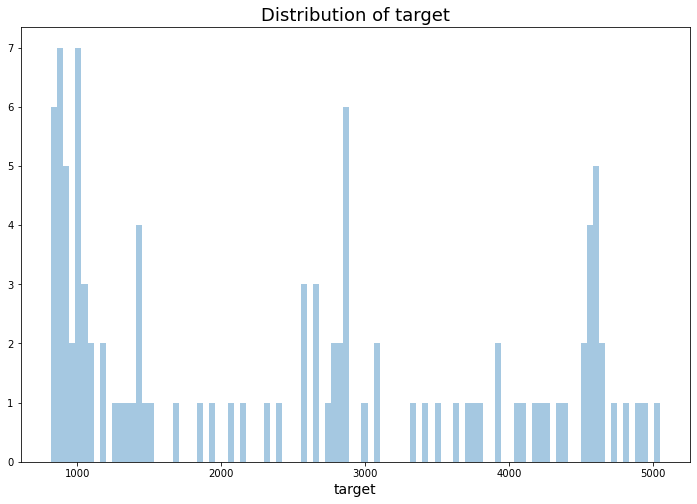

In [5]:
plt.figure(figsize=(12,8))
sns.distplot(data_df.target.values, bins=100, kde=False)
plt.xlabel('target', fontsize=14)
plt.title('Distribution of target', fontsize = 18)
plt.show()

# 뭔가 이 형태 자체가 문제가 있는 것은 아닐까? 분포가 조금 이상한 것 같은데....

시계열 분석

In [6]:
data_df['Date'] = data_df['Date'].apply(trans_date)
data_df['year'] = data_df.Date.apply(lambda x: x.year)
data_df['month_num'] = data_df.Date.apply(lambda x: x.month + 12*(x.year-2020))
data_df['month'] = data_df.Date.apply(lambda x: x.month)
start_date = data_df.Date.min()
data_df['diff_date'] = data_df['Date'].apply(lambda x: (x - start_date).days)
data_df.head()

,Date,target,SCFI-Europe (base port),SCFI-Med (base port),SCFI-WC America (base port),SCFI-EC America (base port),SCFI-Persian Gulf (Dubai),SCFI-ANZ (Melbourne),SCFI-W Africa (Lagos),SCFI-S Africa (Durban),...,Total Containerships - % Idle/Laid Up/Scrubber Retrofit.1,"Containership 1,650/1,850 TEU FCC, G'less Newbuilding Prices","Containership 13,000/14,000 TEU Newbuilding Prices","Containership 3,500/4,000 TEU (Wide Beam) G'less Newbuilding Prices","Containership 13,000/13,500 TEU G'less Newbuilding Prices",5 Year $10m Finance based on Libor 1st yr,year,month_num,month,diff_date
0,2020-01-03,1022.720000,1124.000000,1185.000000,1636.000000,2808.0,1218.000000,949.000000,2744.0,1159.0,...,6.1,26.0,109.0,41.5,98.0,2.19,2020,1,1,0
1,2020-01-10,1002.580000,1058.000000,1179.000000,1543.000000,2888.0,1175.000000,937.000000,2873.0,1150.0,...,6.2,26.0,109.0,41.5,98.0,2.19,2020,1,1,7
2,2020-01-17,990.680000,1010.000000,1180.000000,1562.000000,2943.0,1123.000000,949.000000,2897.0,1084.0,...,6.1,26.0,109.0,41.5,98.0,2.19,2020,1,1,14
3,2020-01-24,981.190000,969.000000,1179.000000,1545.000000,2951.0,1126.000000,942.000000,2908.0,1087.0,...,5.7,26.0,109.0,41.5,98.0,2.18,2020,1,1,21
4,2020-01-31,957.653333,929.333333,1129.666667,1504.333333,2890.0,1113.666667,925.333333,2933.0,1080.0,...,6.3,26.0,109.0,41.5,98.0,2.18,2020,1,1,28


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


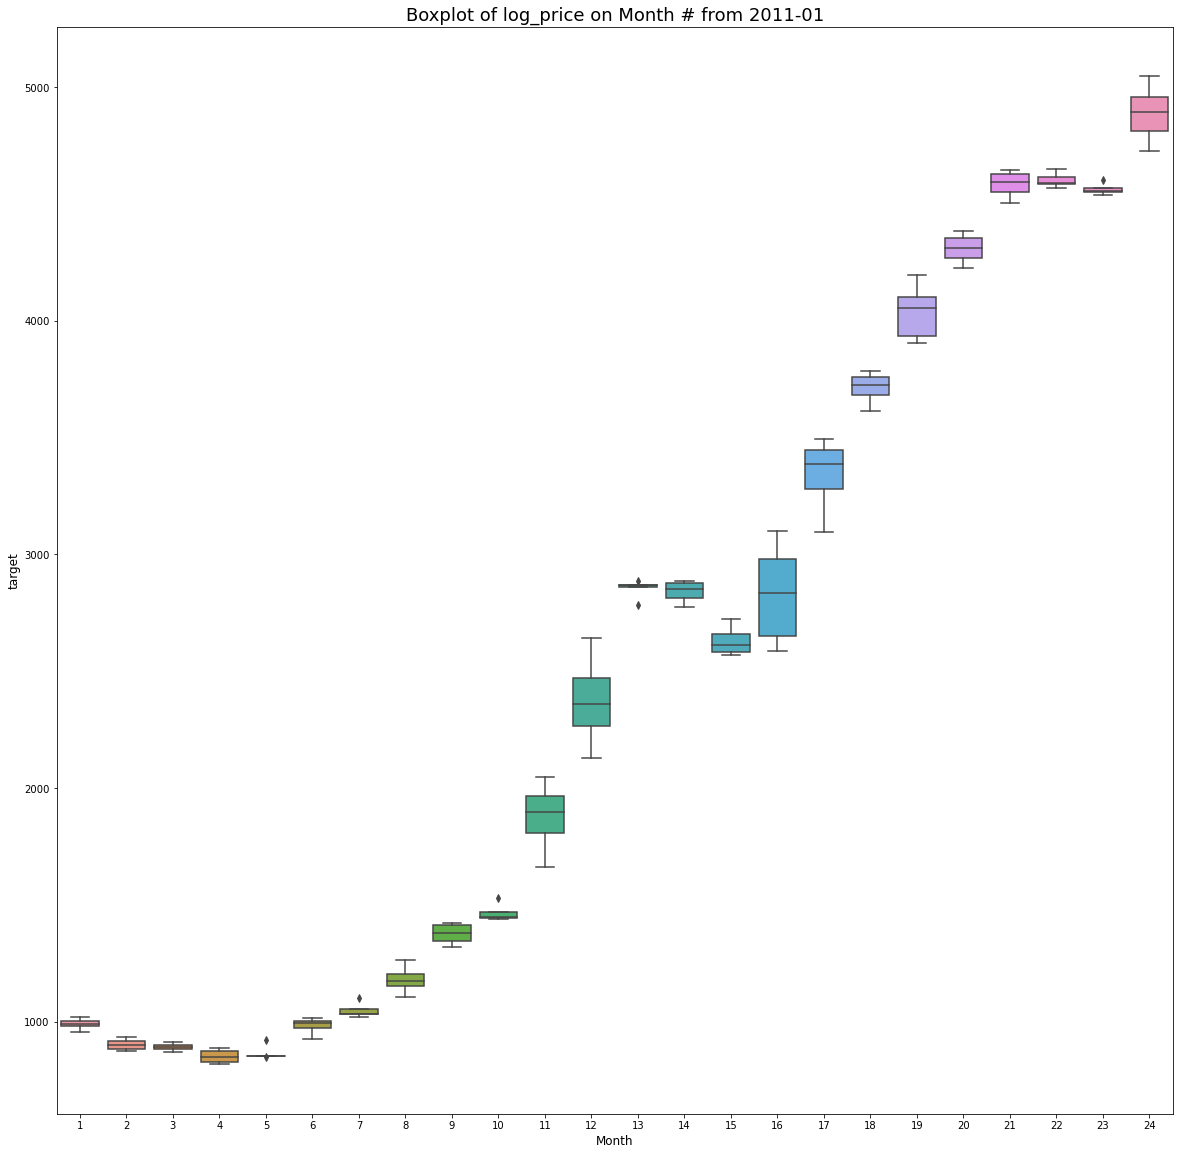

In [8]:
month_num_count = data_df.groupby('month_num').count().reset_index()
month_num_count = data_df.groupby('month_num').size().reset_index()
month_num_count.columns = ['month_num', 'Count']
plt.figure(figsize=(20,20))
sns.boxplot(x = 'month_num', y = 'target', data = data_df)
plt.ylabel('target', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Boxplot of log_price on Month # from 2011-01', fontsize = 18)
plt.show()
# plt.figure(figsize=(12,8))
# sns.distplot(month_num_count.Count.values, bins=50, kde=False)
# plt.xlabel('count of samples per month_num', fontsize=14)
# plt.title('Distribution of count', fontsize = 18)
# plt.show()


# 설명
# 데이터가 시작하는 2020년 1월부터 월 별로 박스 플롯을 그림
# 각 월에 대해서 크게 이상치가 존재하지 않으며, 증가하는 추세를 확인할 수 있음

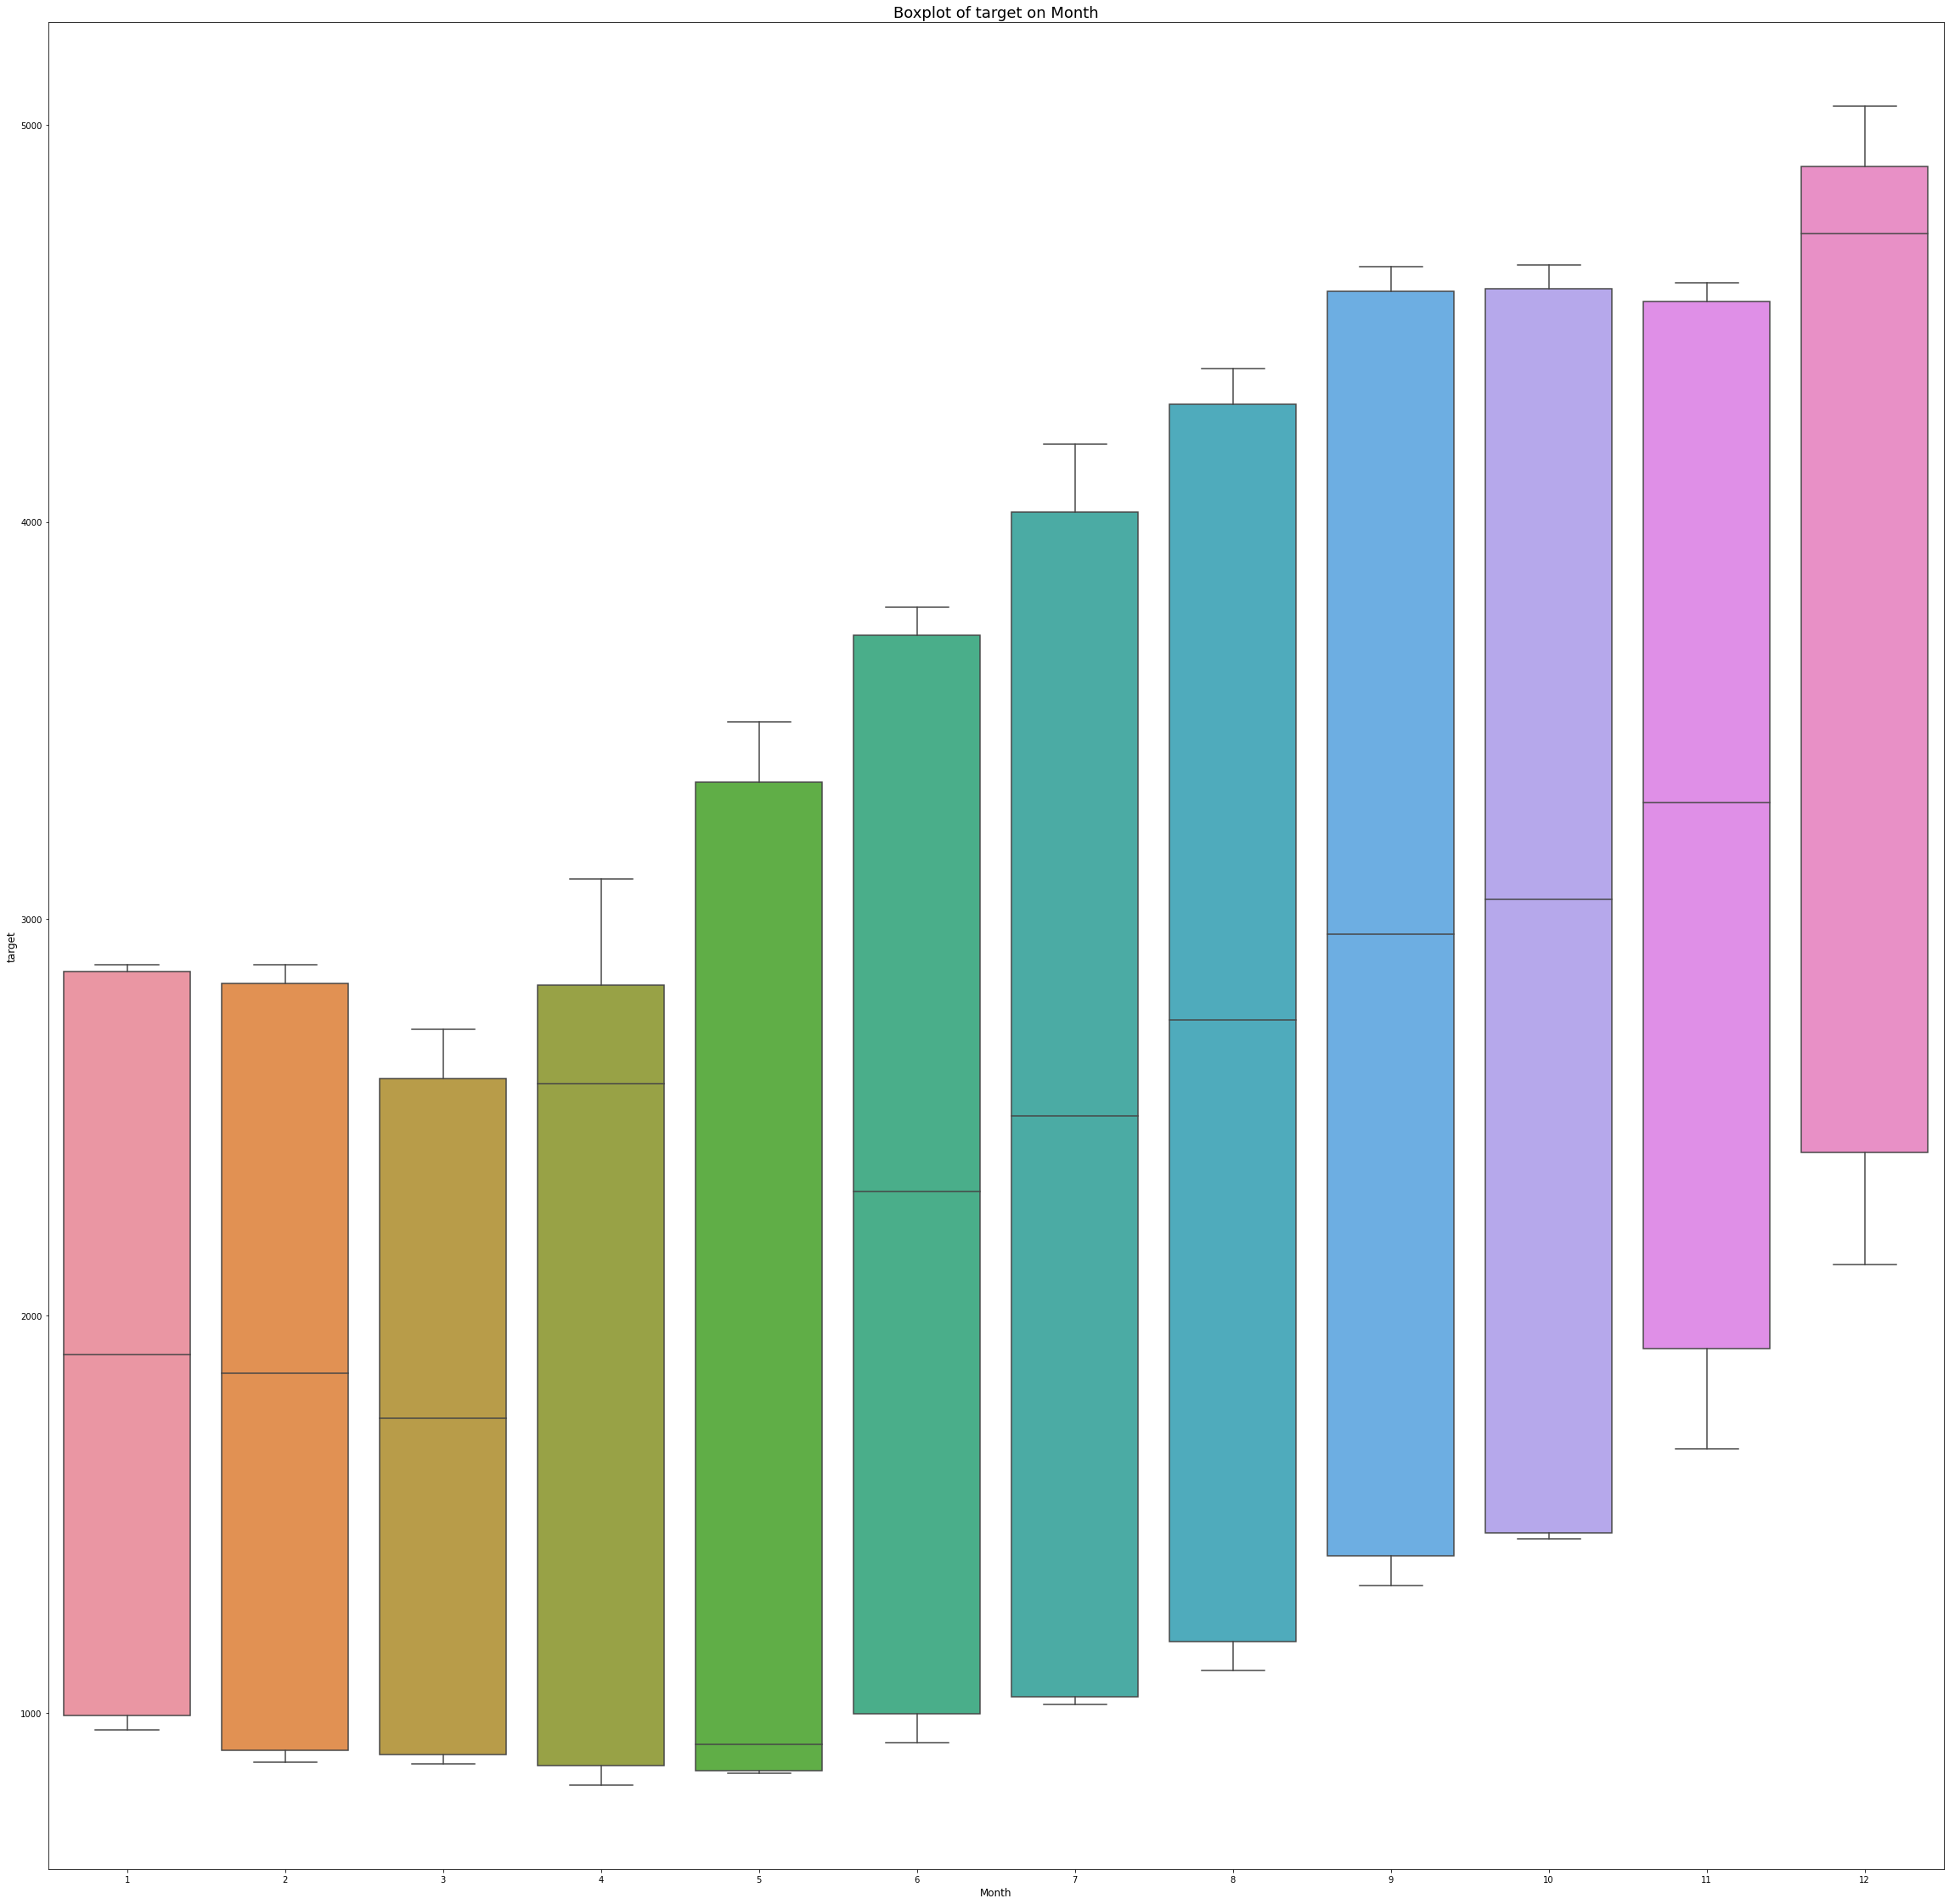

In [9]:
plt.figure(figsize=(40,40))
sns.boxplot(x = 'month', y = 'target', data = data_df)
plt.ylabel('target', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Boxplot of target on Month', fontsize = 18)
plt.show()

# 설명
# 월 별로 종합하니깐 이상치가 아예 없는데.. 이게 맞는지 검증이 필요할듯(도움 요청)
# 증가하는 추세를 확인할 수 있음

Feature selection by correlation

<AxesSubplot:>

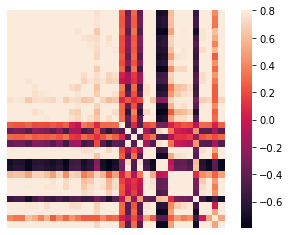

In [10]:
corrmat = data_df.corr()
sns.heatmap(corrmat, vmax=.8, square=True, xticklabels = False, yticklabels = False)

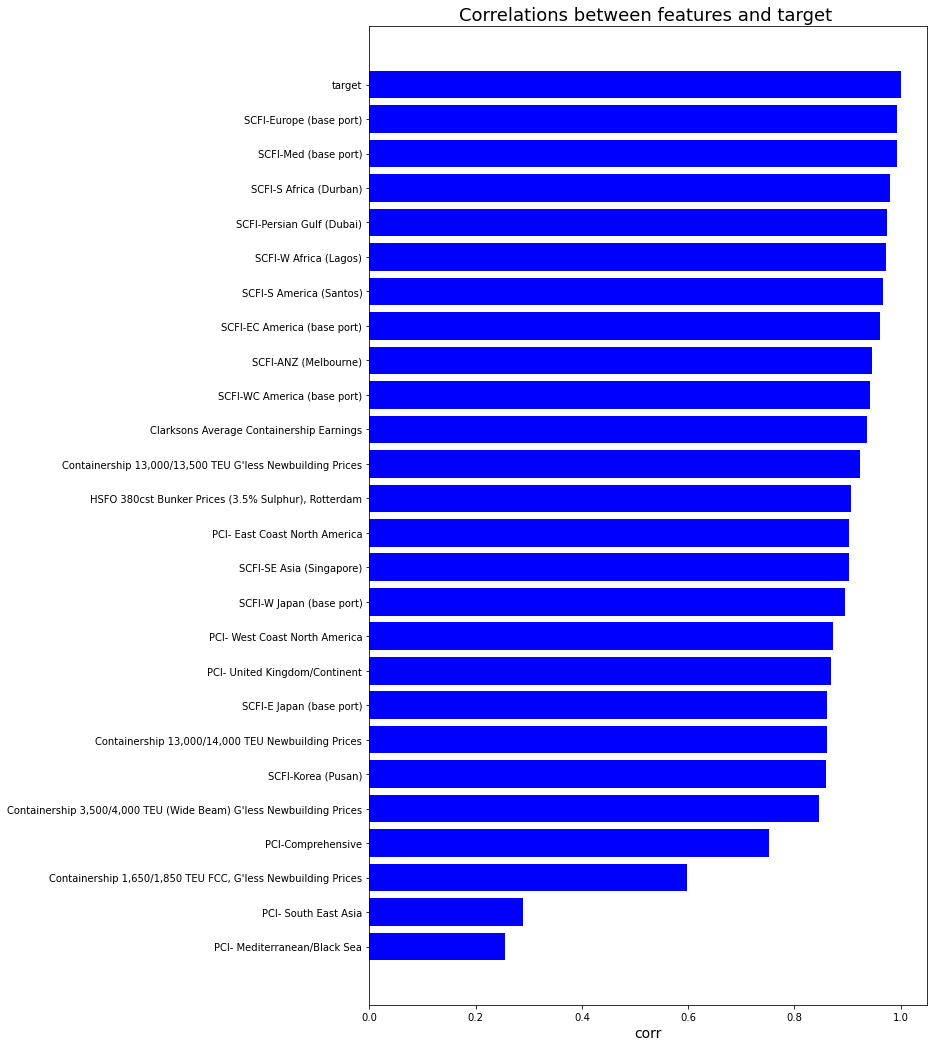

In [11]:
# 전체 SCFI에 대한 상관 관계를 내림차순으로 시각화

corr_target = corrmat['target'].reset_index()[:-4]
corr_target.columns = ['feature','corr']
corr_target = corr_target.sort_values(by = 'corr', ascending = True)[:].loc[corr_target['corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, corr_target['corr'].values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("corr", fontsize = 14)
ax.set_title("Correlations between features and target ", fontsize = 18)
plt.show()

In [32]:
# 전체 SCFI에 대한 상관 관계 중에서 0.7 이상만 검출
# 이 기준(threshold)는 변경 가능

important_value = corr_target.sort_values(by = 'corr', ascending = True)[:].loc[corr_target['corr'] >0.7]
print('전체 SCFI와 상관 관계가 높았던 Feature들은 다음과 같습니다.')
for i in range(len(important_value) - 1) :
    print(important_value.iloc[i, 0], important_value.iloc[i, 1].round(2))


전체 SCFI와 상관 관계가 높았던 Feature들은 다음과 같습니다.
Containership 13,000/13,500 TEU G'less Newbuilding Prices 0.73
SCFI-W Japan (base port) 0.74
Clarksons Average Containership Earnings 0.74
SCFI-EC America (base port) 0.76
PCI- United Kingdom/Continent 0.8
SCFI-Persian Gulf (Dubai) 0.82
SCFI-WC America (base port) 0.83
HSFO 380cst Bunker Prices (3.5% Sulphur), Rotterdam 0.83
SCFI-ANZ (Melbourne) 0.83
SCFI-S Africa (Durban) 0.84
PCI- East Coast North America 0.85
SCFI-Europe (base port) 0.88
SCFI-Med (base port) 0.89
target 0.9
SCFI-Korea (Pusan) 0.9
PCI- West Coast North America 0.9
SCFI-W Africa (Lagos) 0.91
SCFI-S America (Santos) 0.93


In [13]:
corrmat.columns

Index(['target', 'SCFI-Europe (base port)', 'SCFI-Med (base port)',
       'SCFI-WC America (base port)', 'SCFI-EC America (base port)',
       'SCFI-Persian Gulf (Dubai)', 'SCFI-ANZ (Melbourne)',
       'SCFI-W Africa (Lagos)', 'SCFI-S Africa (Durban)',
       'SCFI-S America (Santos)', 'SCFI-W Japan (base port)',
       'SCFI-E Japan (base port)', 'SCFI-SE Asia (Singapore)',
       'SCFI-Korea (Pusan)', 'PCI-Comprehensive',
       'PCI- East Coast North America', 'PCI- West Coast North America',
       'PCI- United Kingdom/Continent', 'PCI- Mediterranean/Black Sea',
       'PCI- East Asia', 'PCI- South East Asia', 'PCI- China P.R.',
       'Clarksons Average Containership Earnings',
       'HSFO 380cst Bunker Prices (3.5% Sulphur), Rotterdam',
       'Total Containerships - % Idle/Laid Up/Scrubber Retrofit',
       'Total Containerships - % Idle/Laid Up/Scrubber Retrofit.1',
       'Containership 1,650/1,850 TEU FCC, G'less Newbuilding Prices',
       'Containership 13,000/14,000 TEU

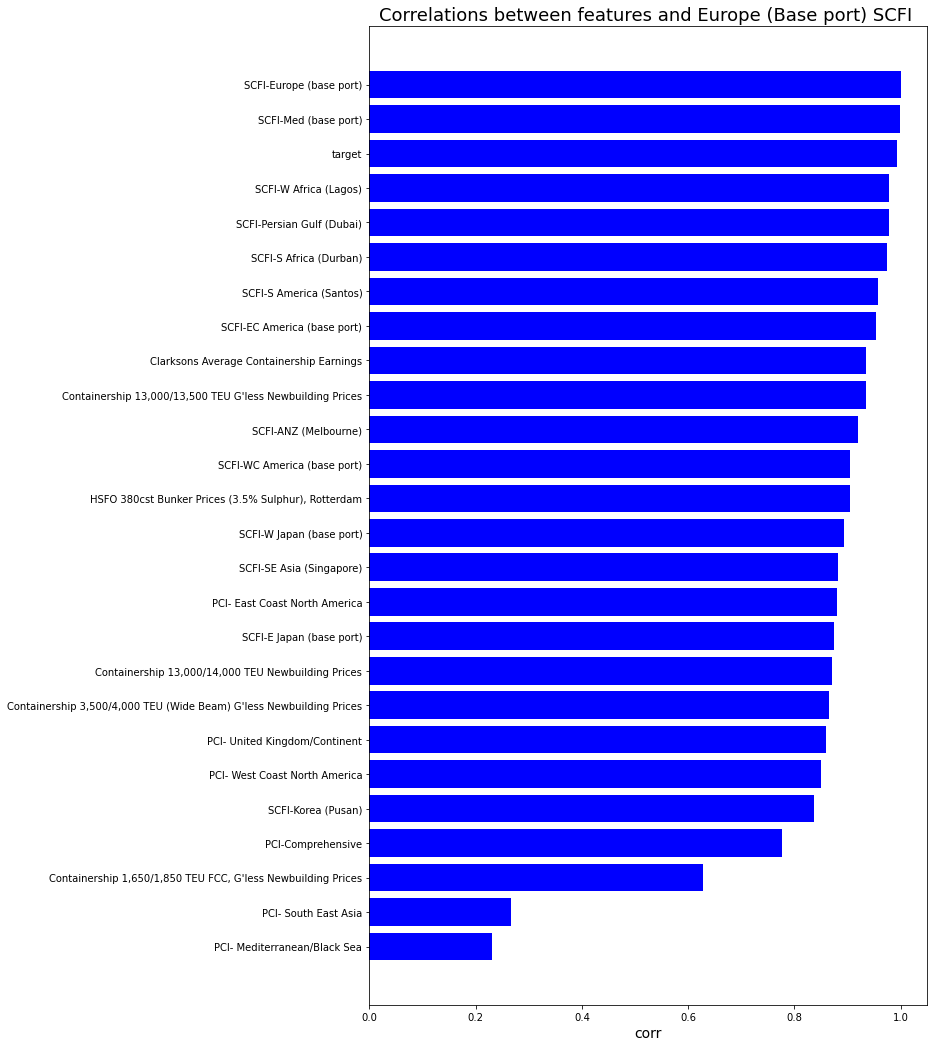

In [14]:
# Europe (Base port) SCFI에 대한 상관 관계를 내림차순으로 시각화

corr_target = corrmat['SCFI-Europe (base port)'].reset_index()[:-4]
corr_target.columns = ['feature','corr']
corr_target = corr_target.sort_values(by = 'corr', ascending = True)[:].loc[corr_target['corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, corr_target['corr'].values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("corr", fontsize = 14)
ax.set_title("Correlations between features and Europe (Base port) SCFI ", fontsize = 18)
plt.show()

In [15]:
# Europe (Base port) SCFI에 대한 상관 관계 중에서 0.7 이상만 검출
# 이 기준(threshold)는 변경 가능

important_value = corr_target.sort_values(by = 'corr', ascending = True)[:].loc[corr_target['corr'] >0.7]
print('Europe (Base port) SCFI와 상관 관계가 높았던 Feature들은 다음과 같습니다.')
for i in range(len(important_value) - 1) :
    print(important_value.iloc[i, 0], important_value.iloc[i, 1].round(2))


Europe (Base port) SCFI와 상관 관계가 높았던 Feature들은 다음과 같습니다.
PCI-Comprehensive 0.78
SCFI-Korea (Pusan) 0.84
PCI- West Coast North America 0.85
PCI- United Kingdom/Continent 0.86
Containership 3,500/4,000 TEU (Wide Beam) G'less Newbuilding Prices 0.86
Containership 13,000/14,000 TEU Newbuilding Prices 0.87
SCFI-E Japan (base port) 0.87
PCI- East Coast North America 0.88
SCFI-SE Asia (Singapore) 0.88
SCFI-W Japan (base port) 0.89
HSFO 380cst Bunker Prices (3.5% Sulphur), Rotterdam 0.9
SCFI-WC America (base port) 0.91
SCFI-ANZ (Melbourne) 0.92
Containership 13,000/13,500 TEU G'less Newbuilding Prices 0.93
Clarksons Average Containership Earnings 0.94
SCFI-EC America (base port) 0.95
SCFI-S America (Santos) 0.96
SCFI-S Africa (Durban) 0.97
SCFI-Persian Gulf (Dubai) 0.98
SCFI-W Africa (Lagos) 0.98
target 0.99
SCFI-Med (base port) 1.0


In [16]:
corrmat['SCFI-Europe (base port)']

# 제가 저장한 2020년 이후 상관관계 사진과 수치가 같은 것을 확인하였습니다.

target                                                                 0.992833
SCFI-Europe (base port)                                                1.000000
SCFI-Med (base port)                                                   0.999125
SCFI-WC America (base port)                                            0.905022
SCFI-EC America (base port)                                            0.954125
SCFI-Persian Gulf (Dubai)                                              0.978112
SCFI-ANZ (Melbourne)                                                   0.918650
SCFI-W Africa (Lagos)                                                  0.978131
SCFI-S Africa (Durban)                                                 0.973248
SCFI-S America (Santos)                                                0.956759
SCFI-W Japan (base port)                                               0.893610
SCFI-E Japan (base port)                                               0.873768
SCFI-SE Asia (Singapore)                

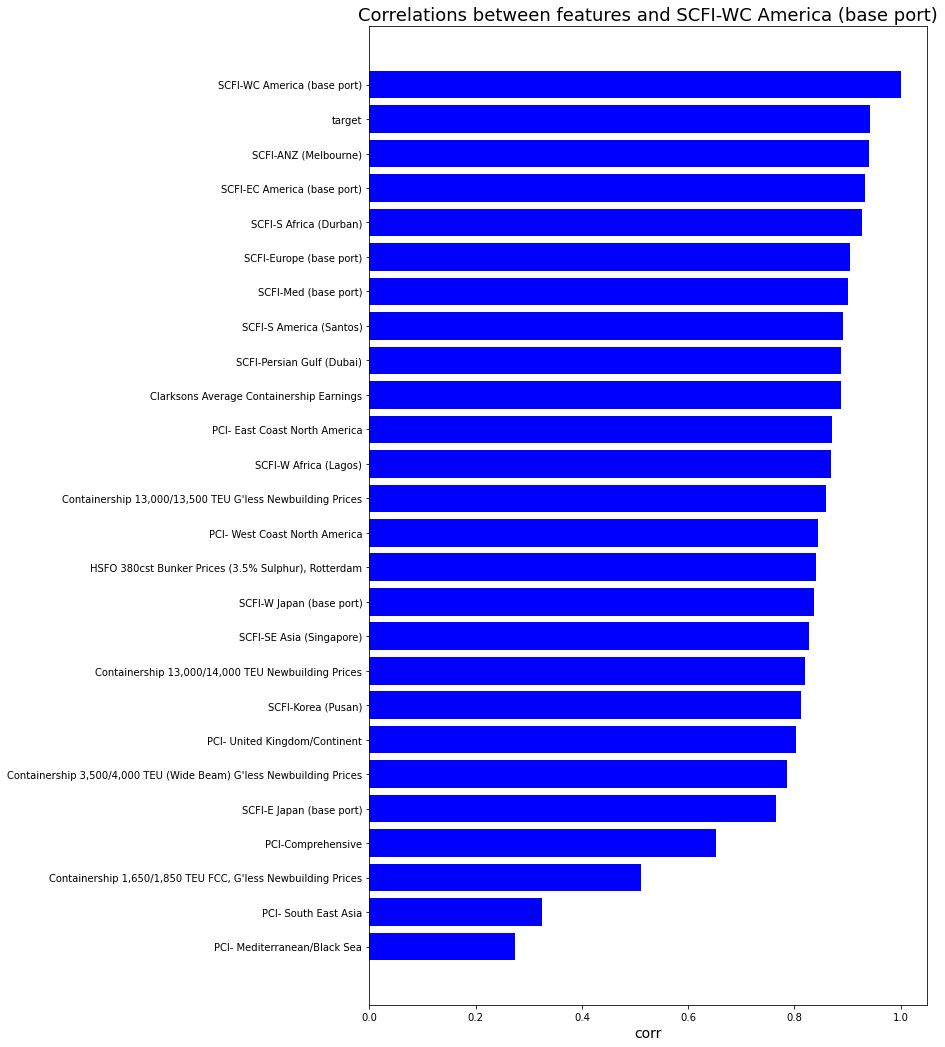

In [17]:
# USWC (Base port) SCFI에 대한 상관 관계를 내림차순으로 시각화

corr_target = corrmat['SCFI-WC America (base port)'].reset_index()[:-4]
corr_target.columns = ['feature','corr']
corr_target = corr_target.sort_values(by = 'corr', ascending = True)[:].loc[corr_target['corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, corr_target['corr'].values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("corr", fontsize = 14)
ax.set_title("Correlations between features and SCFI-WC America (base port)", fontsize = 18)
plt.show()

In [18]:
# USWC (Base port) SCFI에 대한 상관 관계 중에서 0.7 이상만 검출
# 이 기준(threshold)는 변경 가능

important_value = corr_target.sort_values(by = 'corr', ascending = True)[:].loc[corr_target['corr'] >0.7]
print('USWC (Base port) SCFI와 상관 관계가 높았던 Feature들은 다음과 같습니다.')
for i in range(len(important_value) - 1) :
    print(important_value.iloc[i, 0], important_value.iloc[i, 1].round(2))


USWC (Base port) SCFI와 상관 관계가 높았던 Feature들은 다음과 같습니다.
SCFI-E Japan (base port) 0.76
Containership 3,500/4,000 TEU (Wide Beam) G'less Newbuilding Prices 0.79
PCI- United Kingdom/Continent 0.8
SCFI-Korea (Pusan) 0.81
Containership 13,000/14,000 TEU Newbuilding Prices 0.82
SCFI-SE Asia (Singapore) 0.83
SCFI-W Japan (base port) 0.84
HSFO 380cst Bunker Prices (3.5% Sulphur), Rotterdam 0.84
PCI- West Coast North America 0.84
Containership 13,000/13,500 TEU G'less Newbuilding Prices 0.86
SCFI-W Africa (Lagos) 0.87
PCI- East Coast North America 0.87
Clarksons Average Containership Earnings 0.89
SCFI-Persian Gulf (Dubai) 0.89
SCFI-S America (Santos) 0.89
SCFI-Med (base port) 0.9
SCFI-Europe (base port) 0.91
SCFI-S Africa (Durban) 0.93
SCFI-EC America (base port) 0.93
SCFI-ANZ (Melbourne) 0.94
target 0.94


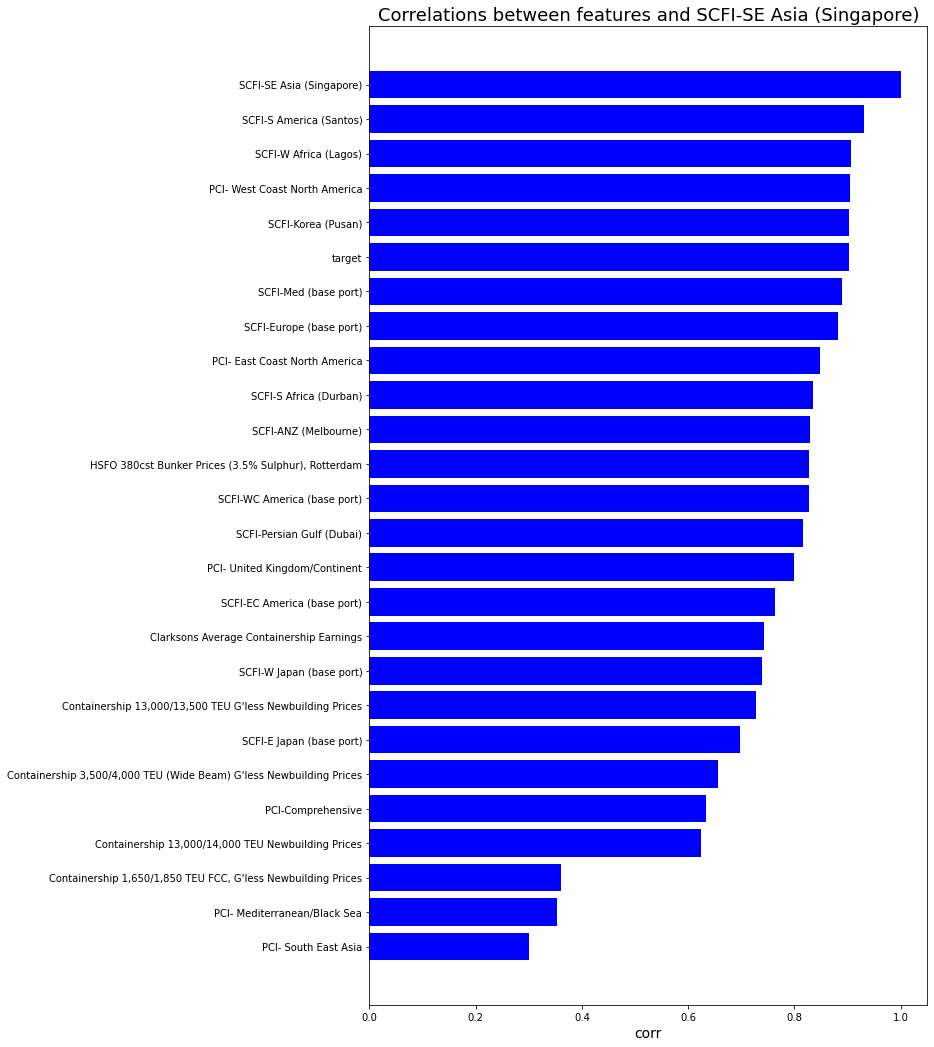

In [19]:
# Southeast Asia (Singapore) SCFI에 대한 상관 관계를 내림차순으로 시각화

corr_target = corrmat['SCFI-SE Asia (Singapore)'].reset_index()[:-4]
corr_target.columns = ['feature','corr']
corr_target = corr_target.sort_values(by = 'corr', ascending = True)[:].loc[corr_target['corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, corr_target['corr'].values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("corr", fontsize = 14)
ax.set_title("Correlations between features and SCFI-SE Asia (Singapore)", fontsize = 18)
plt.show()

In [20]:
# SCFI-SE Asia (Singapore)에 대한 상관 관계 중에서 0.7 이상만 검출
# 이 기준(threshold)는 변경 가능

important_value = corr_target.sort_values(by = 'corr', ascending = True)[:].loc[corr_target['corr'] >0.7]
print('SCFI-SE Asia (Singapore)와 상관 관계가 높았던 Feature들은 다음과 같습니다.')
for i in range(len(important_value) - 1) :
    print(important_value.iloc[i, 0], important_value.iloc[i, 1].round(2))


SCFI-SE Asia (Singapore)와 상관 관계가 높았던 Feature들은 다음과 같습니다.
Containership 13,000/13,500 TEU G'less Newbuilding Prices 0.73
SCFI-W Japan (base port) 0.74
Clarksons Average Containership Earnings 0.74
SCFI-EC America (base port) 0.76
PCI- United Kingdom/Continent 0.8
SCFI-Persian Gulf (Dubai) 0.82
SCFI-WC America (base port) 0.83
HSFO 380cst Bunker Prices (3.5% Sulphur), Rotterdam 0.83
SCFI-ANZ (Melbourne) 0.83
SCFI-S Africa (Durban) 0.84
PCI- East Coast North America 0.85
SCFI-Europe (base port) 0.88
SCFI-Med (base port) 0.89
target 0.9
SCFI-Korea (Pusan) 0.9
PCI- West Coast North America 0.9
SCFI-W Africa (Lagos) 0.91
SCFI-S America (Santos) 0.93


In [21]:
# subplot으로 4개의 SCFI에 대해서 한 번에 출력하는 것은 추후에 진행하겠습니다.
# PPT용으로 만드리기

In [22]:
data_df.columns

Index(['Date', 'target', 'SCFI-Europe (base port)', 'SCFI-Med (base port)',
       'SCFI-WC America (base port)', 'SCFI-EC America (base port)',
       'SCFI-Persian Gulf (Dubai)', 'SCFI-ANZ (Melbourne)',
       'SCFI-W Africa (Lagos)', 'SCFI-S Africa (Durban)',
       'SCFI-S America (Santos)', 'SCFI-W Japan (base port)',
       'SCFI-E Japan (base port)', 'SCFI-SE Asia (Singapore)',
       'SCFI-Korea (Pusan)', 'PCI-Comprehensive',
       'PCI- East Coast North America', 'PCI- West Coast North America',
       'PCI- United Kingdom/Continent', 'PCI- Mediterranean/Black Sea',
       'PCI- East Asia', 'PCI- South East Asia', 'PCI- China P.R.',
       'Clarksons Average Containership Earnings',
       'HSFO 380cst Bunker Prices (3.5% Sulphur), Rotterdam',
       'Total Containerships - % Idle/Laid Up/Scrubber Retrofit',
       'Total Containerships - % Idle/Laid Up/Scrubber Retrofit.1',
       'Containership 1,650/1,850 TEU FCC, G'less Newbuilding Prices',
       'Containership 13,000/14

Feature selection by xgb


In [29]:
# 이렇게 Feature selection하는 방법을 kaggle 코드에서 가져왔습니다. 
# 주소 : https://www.kaggle.com/creatrol/basic-time-series-analysis-feature-selection

train_y = data_df.target.values
train_X = data_df.drop(["Date", "year", "month_num", "month", "target", "diff_date"], axis=1)
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity' : 0
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
remain_num = 99

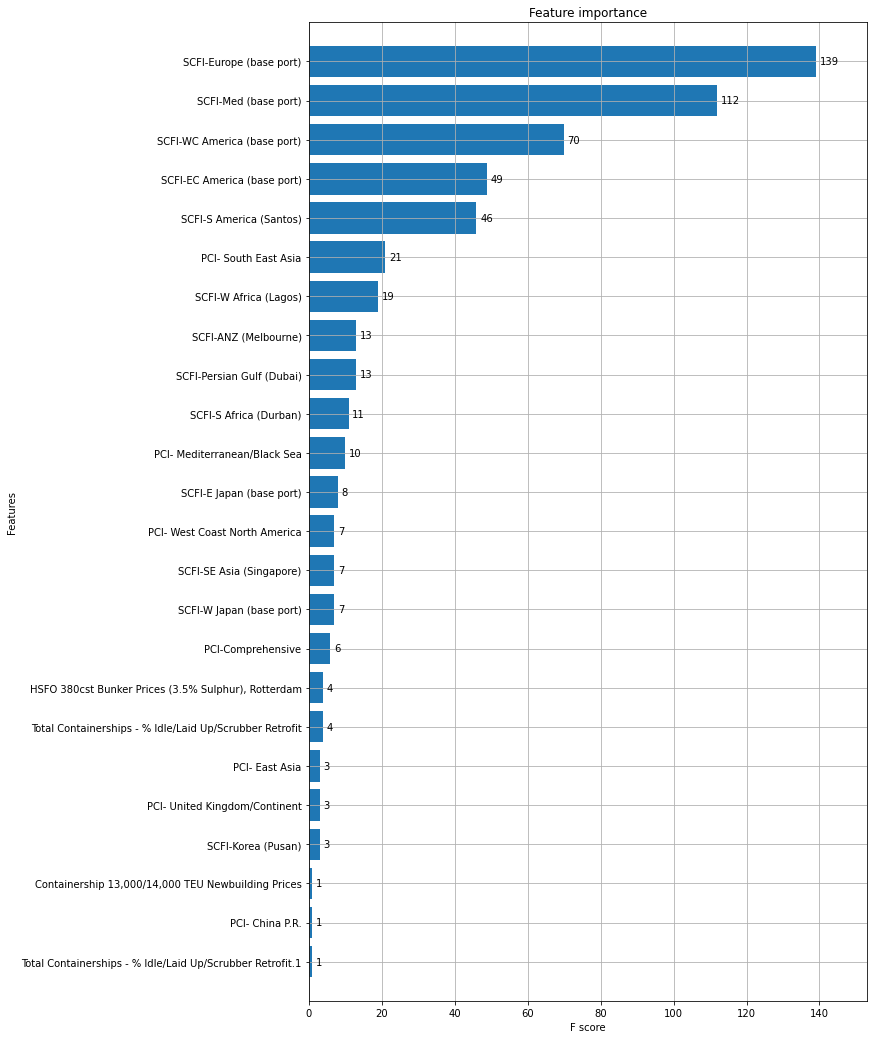

In [30]:
fig, ax = plt.subplots(figsize=(10,18))
xgb.plot_importance(model, max_num_features=remain_num, height=0.8, ax=ax)
plt.show()

# 이상한걸 알 수 있습니다.
# scfi singapore 점수도 낮고 용선료 13000 / 14000 점수도 낮은 것을 확인할 수 있습니다.
# 어떻게 가동되는지도 모르고 그대로 코드를 가져왔기 때문에 정확도가 낮은 것으로 예상합니다.